# Time Series Analysis and Prediction with DARTS in Python

**Notebook Objective:** Train a LightGBM model to predict next 6 months of the 30-years Mortgage rates in the USA.

**Packages:** Pandas, Numpy, Matplotlib, LightGBM, DARTS 

## Imports

In [5]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pandas tool for Time Series
from pandas.tseries.offsets import MonthEnd

# DARTS
from darts import TimeSeries
import darts.utils.statistics as dstats
from darts.utils.utils import ModelMode
from darts.metrics import mae, rmse, mape

# Import LighGBM
from darts.models import LightGBMModel


## Datasets

In [6]:
# Load data
df = pd.read_csv('../.data/mortgage_rates.csv', parse_dates=['dt'])
df = df.query('dt >= "2019-01-01"').reset_index(drop=True)


# Load inflation rates
inflation = pd.read_csv('../.data/inflation_rates.csv', parse_dates=['dt'])
inflation = inflation.query('dt >= "2019-01-01"').reset_index(drop=True)

# Make them data a Darts Time Series object
series = TimeSeries.from_dataframe(df, 'dt', freq='ME')
series2= TimeSeries.from_dataframe(inflation, 'dt', freq='ME')


In [7]:
# Train and Validation split
train, val = series.split_after(0.75) # 75% train, 25% test

## LightGBM in DARTS

In [8]:
# Function to Create features for our data
def var_creator(df):
    '''Function to create time variables for the time series to help with prediction'''
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df


# Function to create laga of the target data
def lags(df, target='mtgage30us'):
    '''Function to create lag of quarter, half year, 1 year of the mortgage rates'''

    target_map = df[target].to_dict()

    df['lag1'] = (df.index - pd.Timedelta('4 W') + MonthEnd(1)).map(target_map) # 1 month lag
    df['lag2'] = (df.index - pd.Timedelta('13 W') + MonthEnd(1)).map(target_map) # 1 quarter lag
    df['lag3'] = (df.index - pd.Timedelta('26 W') + MonthEnd(1)).map(target_map) # 6 months lag
    df['lag4'] = (df.index - pd.Timedelta('52 W') + MonthEnd(1)).map(target_map) # 1 year lag
    df['lag5'] = (df.index - pd.Timedelta('104 W') + MonthEnd(1)).map(target_map) # 2 years lag
    return df

In [ ]:
# Prepare data: Join datasets and set dates as index
data = df.merge(inflation, on='dt', how='inner').set_index('dt')

# Apply functions
data2 = var_creator(data)
data2 = lags(data2)

# View dataset
data2

,mtgage30us,inflation,month,quarter,year,lag1,lag2,lag3,lag4,lag5
dt,,,,,,,,,,
2019-01-31,4.46,1.6,1,1,2019,4.46,NaN,NaN,NaN,NaN
2019-02-28,4.35,1.5,2,1,2019,4.35,NaN,NaN,NaN,NaN
2019-03-31,4.06,1.9,3,1,2019,4.06,NaN,NaN,NaN,NaN
2019-04-30,4.20,2.0,4,2,2019,4.20,4.46,NaN,NaN,NaN
2019-05-31,3.99,1.8,5,2,2019,3.99,4.06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,6.35,2.5,8,3,2024,6.35,6.86,6.79,7.31,6.70
2024-09-30,6.08,2.4,9,3,2024,6.08,6.78,7.17,7.79,7.08
2024-10-31,6.72,2.6,10,4,2024,6.72,6.35,7.03,7.22,6.58


In [10]:
# Define the target variable: predicting 30 yrs Mortgage Rates
target = TimeSeries.from_dataframe(data[['mtgage30us']])

# use past inflation rates as covariates
past_cov = TimeSeries.from_dataframe(data.drop('mtgage30us', axis=1))

# Train and Validation split
train, val = target.split_after(0.9) # 90% train
train_cov, val_cov = past_cov.split_after(0.9)

In [11]:
# Grid Search
lags_list = [1,2,3,4,5,6,7,8,9,10,11,12]

# Model
for lag in lags_list:
    # model
    model = LightGBMModel(
    lags=6, # To predict next month, look at the last `lags` months
    lags_past_covariates=lag, # The model will consider lags and inflation from the past 5 periods to predict Mortgage Rates
    output_chunk_length=len(val), #How many time steps ahead do you want the model to predict at once
    verbose=-1,
    **{ 'objective': 'regression',
        'n_estimators':1000,
        'metric': 'mape',
        'learning_rate': 0.1}
        )

    # Training and validating
    model.fit(train, past_covariates=train_cov)
    pred = model.predict(8)
    print(f'-- Evaluation metric for {lag} lags --\n     MAPE: {round(mape(val, pred),2)}%')


-- Evaluation metric for 1 lags --
     MAPE: 5.11%
-- Evaluation metric for 2 lags --
     MAPE: 5.72%
-- Evaluation metric for 3 lags --
     MAPE: 5.65%
-- Evaluation metric for 4 lags --
     MAPE: 3.68%
-- Evaluation metric for 5 lags --
     MAPE: 3.28%
-- Evaluation metric for 6 lags --
     MAPE: 2.32%
-- Evaluation metric for 7 lags --
     MAPE: 11.0%
-- Evaluation metric for 8 lags --
     MAPE: 17.67%
-- Evaluation metric for 9 lags --
     MAPE: 15.18%
-- Evaluation metric for 10 lags --
     MAPE: 7.53%
-- Evaluation metric for 11 lags --
     MAPE: 3.7%
-- Evaluation metric for 12 lags --
     MAPE: 3.46%


In [12]:
# predict 6 pressure values using the 12 past values of inflation and mortgage rates.
model = LightGBMModel(
    lags=6, # To predict next month, look at the last `lags` months
    lags_past_covariates=6, # The model will consider lags and inflation from the past 5 periods to predict Mortgage Rates
    output_chunk_length=len(val), #How many time steps ahead do you want the model to predict at once
    verbose=-1,
    **{ 'objective': 'regression',
        'n_estimators':1000,
        'metric': 'mape',
        'learning_rate': 0.1})

In [13]:
# Training and validating
model.fit(train, past_covariates=train_cov)
pred = model.predict(len(val))
print(f'-- Evaluation metric --\n     MAPE: {round(mape(val, pred),2)}%')

-- Evaluation metric --
     MAPE: 2.32%


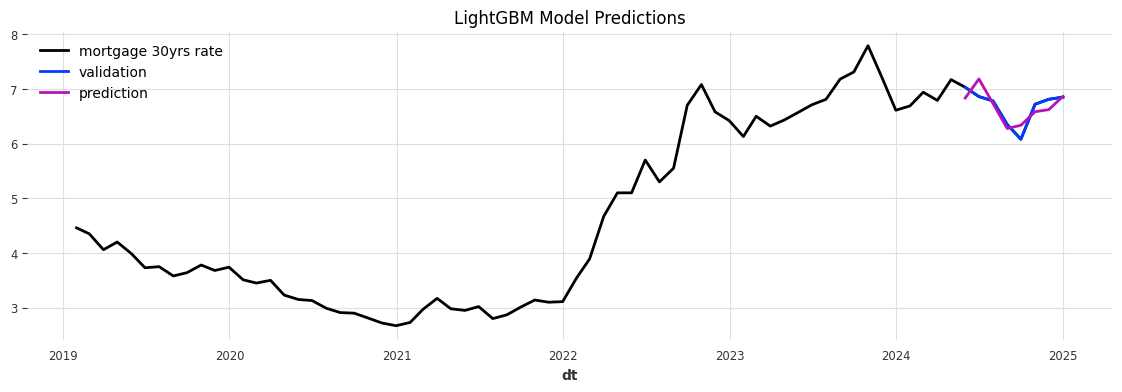

In [18]:
# Plot results
plt.figure(figsize=(14,4))
target.plot(label='mortgage 30yrs rate')
val.plot(label='validation')
pred.plot(label='prediction')
plt.title('LightGBM Model Predictions');

In [15]:
# Fit the model to the entire series
model.fit(target, past_covariates=past_cov)
# Predicting new values
future_predictions = model.predict(len(val))

Forecasted values: [6.74390874 6.61269374 6.41120289 5.79923873 6.01735811 6.05827694
 6.08070569 5.47880023]


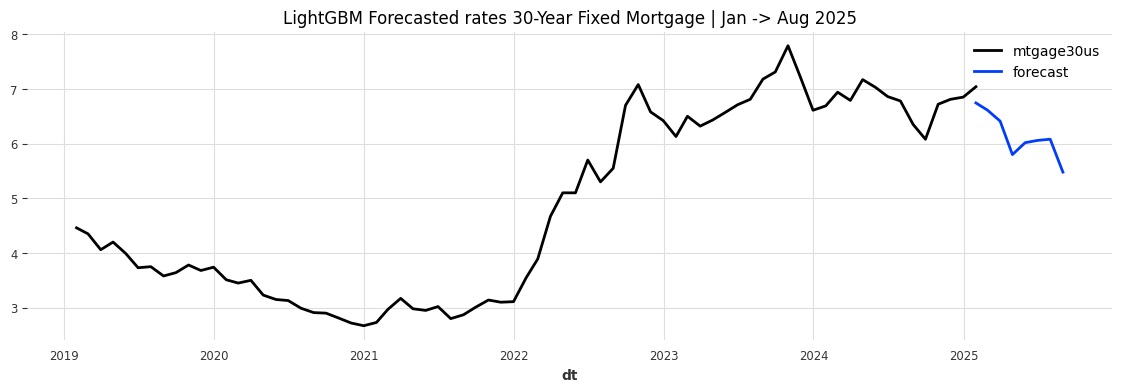

In [20]:
# Print forecasted values
print(f'Forecasted values: {future_predictions.all_values().flatten()}')

# Plot the series
plt.figure(figsize=(14,4))
series.plot()
future_predictions.plot(label='forecast')
plt.title('LightGBM Forecasted rates 30-Year Fixed Mortgage | Jan -> Aug 2025');

## LightGBM (Not Darts wrapper)
This model considers the inflation rates

In [176]:
# import
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_absolute_percentage_error

In [53]:
# Prepare data: Join datasets and set dates as index
data = df.merge(inflation, on='dt', how='inner').set_index('dt')

<Axes: title={'center': '30yr-Mortgage Rates versus Inflation USA'}, xlabel='dt'>

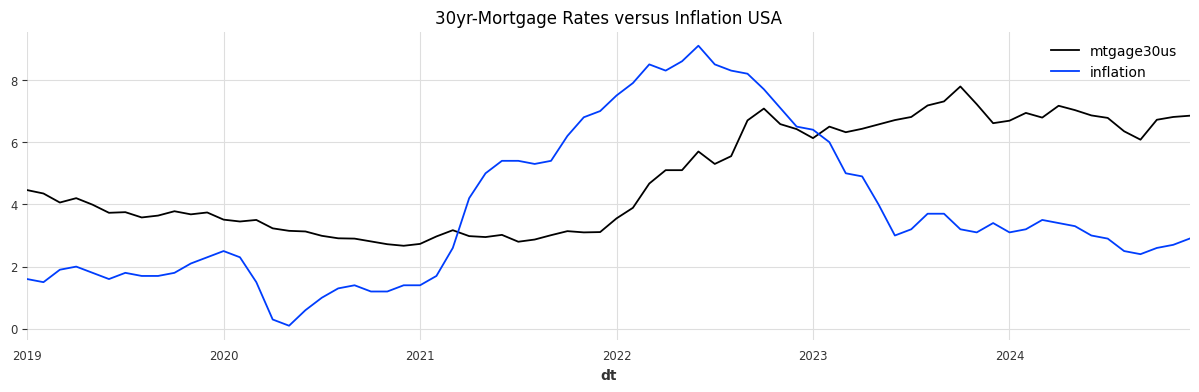

In [54]:
# Plot
data.plot(figsize=(15,4), title="30yr-Mortgage Rates versus Inflation USA")

In [320]:
# Creating features for our data
def var_creator(df):
    '''Function to create time variables for the time series to help with prediction'''
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df


# Function to create lag of 1, 2, and 3 years of the data
def lags(df, target='mtgage30us'):
    '''Function to create lag of 1 to 3 years of the mortgage rates'''

    target_map = df[target].to_dict()

    df['lag1'] = (df.index - pd.Timedelta('13 W') + MonthEnd(1)).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('26 W') + MonthEnd(1)).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('52 W') + MonthEnd(1)).map(target_map)
    return df

In [322]:
# Time series split for Cross Validation
tss = TimeSeriesSplit(n_splits=5, test_size=12)

# Sort index
data.sort_index(inplace=True)

fold = 0
preds = []
scores = []

for train_idx, test_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[test_idx]

    # Create train and test sets and add variables month, quarter and year
    train = var_creator(train)
    train = lags(train)
    test = var_creator(test)
    test = lags(test)

    # Set up variables for X and Y
    features = ['month', 'quarter', 'year', 'lag1','lag2', 'lag3', 'inflation']
    target = ['mtgage30us']

    # Define X and Y
    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    # Model
    train_data = lgb.Dataset(X_train, label=y_train)
    params = {
        'force_col_wise': True,
        'objective': 'regression',
        'metric': 'mape',
        'learning_rate': 0.1
    }

    # Fit model
    model = lgb.train(params, train_data, num_boost_round=100)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there ar

In [323]:
# Cross-Validation results
print(f'Mean score: {np.mean(scores)}')
print(f'Scores: {scores}')

Mean score: 0.22923442320698267
Scores: [0.28095969087749706, 0.17284414300596443, 0.365725307839249, 0.2634734951050346, 0.06316947920716849]


In [324]:

data2 = data.copy()
data2 = var_creator(data2)
data2 = lags(data2)
predictions = model.predict(data2[features])

data2['preds'] = predictions

MAPE: 0.04084249711777475


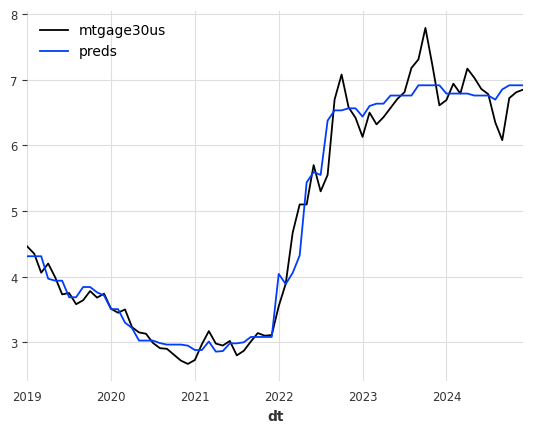

In [325]:
# MAPE
print(f'MAPE: {mean_absolute_percentage_error(data2.mtgage30us, data2.preds)}')
data2[['mtgage30us', 'preds']].plot();

In [326]:
data2 = lags(data2)

In [327]:
data2

,mtgage30us,inflation,month,quarter,year,lag1,lag2,lag3,preds
dt,,,,,,,,,
2019-01-31,4.46,1.6,1,1,2019,NaN,NaN,NaN,4.310841
2019-02-28,4.35,1.5,2,1,2019,NaN,NaN,NaN,4.310841
2019-03-31,4.06,1.9,3,1,2019,NaN,NaN,NaN,4.310841
2019-04-30,4.20,2.0,4,2,2019,4.46,NaN,NaN,3.968326
2019-05-31,3.99,1.8,5,2,2019,4.06,NaN,NaN,3.938200
...,...,...,...,...,...,...,...,...,...
2024-08-31,6.35,2.5,8,3,2024,6.86,6.79,7.31,6.697526
2024-09-30,6.08,2.4,9,3,2024,6.78,7.17,7.79,6.853585
2024-10-31,6.72,2.6,10,4,2024,6.35,7.03,7.22,6.915764


In [328]:
# Getting all the dataset for training
X_all = data2[features]
y_all = data2[target]

# Model
train_data = lgb.Dataset(X_all, label=y_all)
params = {
    'force_col_wise': True,
    'objective': 'regression',
    'metric': 'mape',
    'learning_rate': 0.1,
    'verbose':0
}
# Fit model
model = lgb.train(params, train_data, num_boost_round=100)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [329]:
# Get the initial data for future forecast
data.index.max()

Timestamp('2024-12-31 00:00:00')

In [364]:
# Create Future dataframe
future_dates = pd.date_range(start='2025-01-01',
                             end= '2025-06-30',
                             freq='ME')

# Future Data frame
future_df = pd.DataFrame(index=future_dates)
future_df['inflation'] = 2.5

# Identificator for future dates
future_df['is_future'] = True
data2['is_future'] = False

# Join data
df_all = pd.concat([data2, future_df])


In [365]:
df_all = var_creator(df_all)
df_all = lags(df_all)

In [366]:
df_all

,mtgage30us,inflation,month,quarter,year,lag1,lag2,lag3,preds,is_future
2019-01-31,4.46,1.6,1,1,2019,NaN,NaN,NaN,4.310841,False
2019-02-28,4.35,1.5,2,1,2019,NaN,NaN,NaN,4.310841,False
2019-03-31,4.06,1.9,3,1,2019,NaN,NaN,NaN,4.310841,False
2019-04-30,4.20,2.0,4,2,2019,4.46,NaN,NaN,3.968326,False
2019-05-31,3.99,1.8,5,2,2019,4.06,NaN,NaN,3.938200,False
...,...,...,...,...,...,...,...,...,...,...
2025-02-28,NaN,2.5,2,1,2025,6.81,6.35,6.79,NaN,True
2025-03-31,NaN,2.5,3,1,2025,6.85,6.72,7.17,NaN,True
2025-04-30,NaN,2.5,4,2,2025,NaN,6.72,7.03,NaN,True
2025-05-31,NaN,2.5,5,2,2025,NaN,6.85,6.86,NaN,True


In [367]:
df_all['prediction'] = model.predict(df_all[features])

In [368]:
df_all

,mtgage30us,inflation,month,quarter,year,lag1,lag2,lag3,preds,is_future,prediction
2019-01-31,4.46,1.6,1,1,2019,NaN,NaN,NaN,4.310841,False,4.250730
2019-02-28,4.35,1.5,2,1,2019,NaN,NaN,NaN,4.310841,False,4.250730
2019-03-31,4.06,1.9,3,1,2019,NaN,NaN,NaN,4.310841,False,4.250730
2019-04-30,4.20,2.0,4,2,2019,4.46,NaN,NaN,3.968326,False,3.908025
2019-05-31,3.99,1.8,5,2,2019,4.06,NaN,NaN,3.938200,False,3.848723
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,NaN,2.5,2,1,2025,6.81,6.35,6.79,NaN,True,6.860440
2025-03-31,NaN,2.5,3,1,2025,6.85,6.72,7.17,NaN,True,6.693934
2025-04-30,NaN,2.5,4,2,2025,NaN,6.72,7.03,NaN,True,5.309836
2025-05-31,NaN,2.5,5,2,2025,NaN,6.85,6.86,NaN,True,5.250534


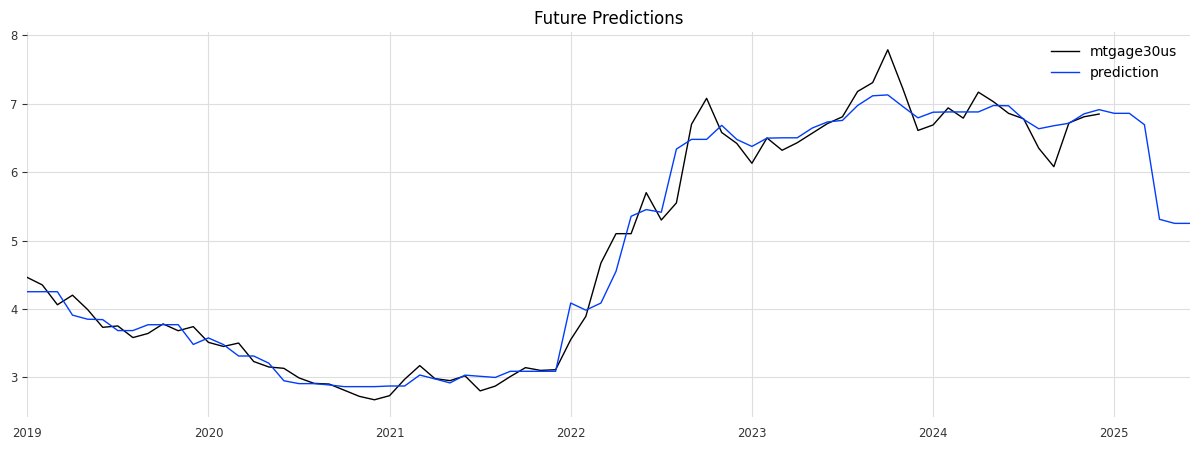

In [369]:
df_all[['mtgage30us', 'prediction']].plot(figsize=(15,5),
            ms=1, lw=1,
            title='Future Predictions');

In [370]:
mean_absolute_percentage_error(df_all.iloc[:72].mtgage30us, df_all.iloc[:72].prediction)

0.034672774259124656

In [371]:
df_all.tail(10)

,mtgage30us,inflation,month,quarter,year,lag1,lag2,lag3,preds,is_future,prediction
2024-09-30,6.08,2.4,9,3,2024,6.78,7.17,7.79,6.853585,False,6.678976
2024-10-31,6.72,2.6,10,4,2024,6.35,7.03,7.22,6.915764,False,6.715098
2024-11-30,6.81,2.7,11,4,2024,6.08,6.86,6.61,6.915764,False,6.852568
2024-12-31,6.85,2.9,12,4,2024,6.72,6.78,6.69,6.915764,False,6.914138
2025-01-31,NaN,2.5,1,1,2025,6.81,6.35,6.94,NaN,True,6.860440
2025-02-28,NaN,2.5,2,1,2025,6.81,6.35,6.79,NaN,True,6.860440
2025-03-31,NaN,2.5,3,1,2025,6.85,6.72,7.17,NaN,True,6.693934
2025-04-30,NaN,2.5,4,2,2025,NaN,6.72,7.03,NaN,True,5.309836
2025-05-31,NaN,2.5,5,2,2025,NaN,6.85,6.86,NaN,True,5.250534
2025-06-30,NaN,2.5,6,2,2025,NaN,6.85,6.78,NaN,True,5.250534


In [644]:
future_predictions

<TimeSeries (DataArray) (dt: 8, component: 1, sample: 1)> Size: 64B
array([[[6.76221312]],

       [[6.71413848]],

       [[6.57122002]],

       [[6.43407152]],

       [[6.27860802]],

       [[6.01781153]],

       [[5.79792839]],

       [[5.06626755]]])
Coordinates:
  * dt         (dt) datetime64[ns] 64B 2025-01-31 2025-02-28 ... 2025-08-31
  * component  (component) object 8B 'mtgage30us'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None